# MultiNorm

This is a tutorial notebook for the ``MultiNorm`` class from the ``multinorm`` Python package ([Github](https://github.com/cdeil/multinorm)).

- A quick tutorial introduction (~ 5 min read)
- Explain and illustrate some of the theory / statistical aspects
- Hands-on introduction how to work with ``MultiNorm`` class.

Suggestions:

- Read this tutorial and judge if `multinorm` is useful for you.
- If yes, install it with `pip install multinorm`, download this notebook, and execute / play with these examples on your machine.
- Learn more at https://multinorm.readthedocs.io (complete description of features and theory).

## Introduction

- TODO: What is MVN (theory)?
- https://en.wikipedia.org/wiki/Multivariate_normal_distribution
- TODO: What is `MultiNorm` (code)?

## Example

TODO: Fit with scipy, analyse fit result with `MultiNorm`.

In [1]:
from multinorm import MultiNorm

In [2]:
from multinorm import MultiNorm
mean = [10, 20, 30]
covariance = [[1, 0, 0], [0, 4, 0], [0, 0, 9]]
names = ["a", "b", "c"]
mn = MultiNorm(mean, covariance, names)

In [3]:
mn.pandas_summary

,mean,err
name,,
a,10.0,1.0
b,20.0,2.0
c,30.0,3.0


      mean  err
name           
a     10.0  1.0
b     20.0  2.0


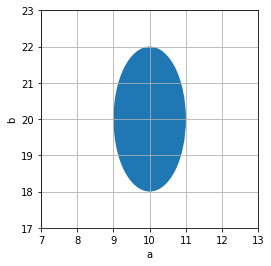

In [7]:
mn2 = mn.marginal(["a", "b"])
print(mn2.pandas_summary)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ellipse = mn2.to_matplotlib_ellipse()
ax.add_artist(ellipse)
ax.set_xlim(7, 13)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_ylim(17, 23)
ax.grid(True)
plt.show()

## Summary

Let us recap the most important points concerning multivariante normal distributions and the `MultiNorm` class.

To learn more: https://multinorm.readthedocs.io

### Theory

- TODO: MVN are ...

### Code

- TODO: the `MultiNorm` class ...

## Exercises

- TODO